# Timeseries Analysis with ARIMA and Prophet

In [1]:
# importing Python modules
import os
import sys #access to system parameters https://docs.python.org/3/library/sys.html
print("Python version: {}". format(sys.version))
print("Python environment: {}".format(sys.executable))

import pandas as pd 
from pandas import ExcelWriter
from pandas import ExcelFile
from openpyxl import load_workbook
print("pandas version: {}". format(pd.__version__))

import plotly_express as px
import matplotlib #collection of functions for scientific and publication-ready visualization
import matplotlib.pyplot as plt # for plotting
%matplotlib inline
plt.style.use('fivethirtyeight')
matplotlib.rcParams['axes.labelsize'] = 13
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
print("matplotlib version: {}". format(matplotlib.__version__))
import seaborn as sns # for making plots with seaborn
color = sns.color_palette()
print("seaborn version: {}". format(sns.__version__))

import numpy as np #foundational package for scientific computing
print("NumPy version: {}". format(np.__version__))
import scipy as sp #collection of functions for scientific computing and advance mathematics
from scipy import stats
from scipy.stats import norm, skew
print("SciPy version: {}". format(sp.__version__)) 
import statsmodels.api as sm
import itertools

import IPython
from IPython import display #pretty printing of dataframes in Jupyter notebook
from IPython.display import display
pd.options.display.max_columns = None
print("IPython version: {}". format(IPython.__version__)) 

import datetime
from datetime import datetime
from dateutil.parser import parse

# to make this notebook's output identical at every run
np.random.seed(42)

import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

%load_ext autoreload
%autoreload 2
print("Imported required Python packages")

Python version: 3.6.8 |Anaconda custom (64-bit)| (default, Dec 29 2018, 19:04:46) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
Python environment: /Users/hamzabendemra/anaconda3/bin/python
pandas version: 0.24.2
matplotlib version: 2.1.2
seaborn version: 0.8.1
NumPy version: 1.16.3
SciPy version: 1.2.1
IPython version: 6.2.1


<IPython.core.display.Javascript object>

Imported required Python packages


In [2]:
import warnings
warnings.filterwarnings("ignore")

**Timeseries Analysis** steps:
1. Define the Problem and Assumptions <br>
2. Exploratory Data Analysis <br>
    2.1 Get the Data <br>
    2.3 Quick Glance <br>
3. Data Processing <br>
4. EDA <br>
5. Build Timeseries Model <br>
    5.1 Baseline Models <br>
    5.2 Evaluate Model <br>
    5.3 Fine-tune Model <br>
6. Provide forecast <br>

## Define the Problem

In this mini-project, I will a timeseries analysis of sales data for a fictional "SuperStore" which sells various items. The dataset is sourced from Tableau. <br>
Source: [XLS datasource](https://community.tableau.com/docs/DOC-1236) <br>

The primary aims of this analysis are to: 
1. Clearly define the step-by-step process required for timeseries analysis, and 
2. Provide a 5-year sales forecast (with confidence intervals) in graphical and tabular form.

**Problem type**: Timeseries forecasting <br>
**Data source**: Tabular; 4 years of sales; transaction-level records <br>
**Timeseries Models:** ARIMA (SARIMAX), Prophet <br>
**Performance metric**: RMSE (root mean-squared error) <br>
**Deliverable**: XLS spreadsheet for forecast for the next 5 years <br>

Another performance metric to investigate: **MAPE** (Mean Absolute Percent Error)

> One of the methods available in Python to model and predict future points of a time series is known as **SARIMAX**, which stands for **Seasonal AutoRegressive Integrated Moving Averages with eXogenous regressors**. <br> In this study, we will primarily focus on the ARIMA component, which is used to fit time-series data to better understand and forecast future points in the time series.

## Exploratory Data Analysis

### Get the data

In [3]:
df = pd.read_excel("data/Superstore.xls")
print(df.shape)

(9994, 21)


In [4]:
df.head(3)

Row ID        Order ID Order Date  Ship Date     Ship Mode Customer ID  \
0       1  CA-2016-152156 2016-11-08 2016-11-11  Second Class    CG-12520   
1       2  CA-2016-152156 2016-11-08 2016-11-11  Second Class    CG-12520   
2       3  CA-2016-138688 2016-06-12 2016-06-16  Second Class    DV-13045   

     Customer Name    Segment        Country         City       State  \
0      Claire Gute   Consumer  United States    Henderson    Kentucky   
1      Claire Gute   Consumer  United States    Henderson    Kentucky   
2  Darrin Van Huff  Corporate  United States  Los Angeles  California   

   Postal Code Region       Product ID         Category Sub-Category  \
0        42420  South  FUR-BO-10001798        Furniture    Bookcases   
1        42420  South  FUR-CH-10000454        Furniture       Chairs   
2        90036   West  OFF-LA-10000240  Office Supplies       Labels   

                                        Product Name   Sales  Quantity  \
0                  Bush Somerset Collection Bookcase  261.96         2   
1  Hon Deluxe Fabric Upholstered Stacking Chairs,...  731.94         3   
2  Self-Adhesive Address Labels for Typewriters b...   14.62         2   

   Discount    Profit  
0       0.0   41.9136  
1       0.0  219.5820  
2       0.0    6.8714

In [5]:
df['Category'].value_counts()

Office Supplies    6026
Furniture          2121
Technology         1847
Name: Category, dtype: int64

In [6]:
df_furniture = df[df['Category']=='Furniture'].copy()
print(df_furniture.shape)

(2121, 21)


In [7]:
# check that there are no missing values
df.isnull().sum()

Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64

### Quick glance

In [8]:
df_furniture.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

In [9]:
# let's break down the columns by their type (i.e. int64, float64, object)
df_furniture.columns.to_series().groupby(df_furniture.dtypes).groups

{dtype('int64'): Index(['Row ID', 'Postal Code', 'Quantity'], dtype='object'),
 dtype('<M8[ns]'): Index(['Order Date', 'Ship Date'], dtype='object'),
 dtype('float64'): Index(['Sales', 'Discount', 'Profit'], dtype='object'),
 dtype('O'): Index(['Order ID', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment',
        'Country', 'City', 'State', 'Region', 'Product ID', 'Category',
        'Sub-Category', 'Product Name'],
       dtype='object')}

In [10]:
df_furniture.describe()

Row ID   Postal Code        Sales     Quantity     Discount  \
count  2121.000000   2121.000000  2121.000000  2121.000000  2121.000000   
mean   5041.643564  55726.556341   349.834887     3.785007     0.173923   
std    2885.740258  32261.888225   503.179145     2.251620     0.181547   
min       1.000000   1040.000000     1.892000     1.000000     0.000000   
25%    2568.000000  22801.000000    47.040000     2.000000     0.000000   
50%    5145.000000  60505.000000   182.220000     3.000000     0.200000   
75%    7534.000000  90032.000000   435.168000     5.000000     0.300000   
max    9991.000000  99301.000000  4416.174000    14.000000     0.700000   

            Profit  
count  2121.000000  
mean      8.699327  
std     136.049246  
min   -1862.312400  
25%     -12.849000  
50%       7.774800  
75%      33.726600  
max    1013.127000

In [11]:
px.violin(data_frame=df,
          y="Sales",
          color='Category',
          title="Furniture Sales Distribution (Violin Plot)")

In [12]:
df_furniture.head(1)

Row ID        Order ID Order Date  Ship Date     Ship Mode Customer ID  \
0       1  CA-2016-152156 2016-11-08 2016-11-11  Second Class    CG-12520   

  Customer Name   Segment        Country       City     State  Postal Code  \
0   Claire Gute  Consumer  United States  Henderson  Kentucky        42420   

  Region       Product ID   Category Sub-Category  \
0  South  FUR-BO-10001798  Furniture    Bookcases   

                        Product Name   Sales  Quantity  Discount   Profit  
0  Bush Somerset Collection Bookcase  261.96         2       0.0  41.9136

In [13]:
df_furniture.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

In [14]:
furniture = df_furniture[['Order Date', 'Sales']].copy()
furniture.head(1)

Order Date   Sales
0 2016-11-08  261.96

In [15]:
print("The dataset contains {:.2f} years of Furniture sales.".format(
    (furniture['Order Date'].max()-furniture['Order Date'].min()).days / 365))

The dataset contains 3.98 years of Furniture sales.


## Data Processing

### Sort sales by date

In [16]:
# sort sales by Order Date
furniture = furniture.sort_values('Order Date').reset_index(drop=True)
furniture.head(3)

Order Date     Sales
7474 2014-01-06  2573.820
7660 2014-01-07    76.728
866  2014-01-10    51.940

### Group sales by order date, and sum them up

In [18]:
# Group sales by order date, and sum them up
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
print(furniture.shape)
furniture.head()

(889, 2)


Order Date     Sales
0 2014-01-06  2573.820
1 2014-01-07    76.728
2 2014-01-10    51.940
3 2014-01-11     9.940
4 2014-01-13   879.939

### Set OrderDate as index

In [19]:
# set orderdate as index
furniture = furniture.set_index('Order Date')
print(furniture.shape)
furniture.head(3)

(889, 1)


Sales
Order Date          
2014-01-06  2573.820
2014-01-07    76.728
2014-01-10    51.940

### Resample sales data (monthly average with first day of month as timestamp)

In [20]:
# resamplign dataframe into monthly averages with start of each month as the timestamp.
y = furniture['Sales'].resample("MS").mean().copy()
print(type(y))
y.head()

<class 'pandas.core.series.Series'>


Order Date
2014-01-01    480.194231
2014-02-01    367.931600
2014-03-01    857.291529
2014-04-01    567.488357
2014-05-01    432.049188
Freq: MS, Name: Sales, dtype: float64

## EDA

In [21]:
df_furn_monthly = y.to_frame()
df_furn_monthly['Order Date'] = df_furn_monthly.index
df_furn_monthly.head(3)

Sales Order Date
Order Date                       
2014-01-01  480.194231 2014-01-01
2014-02-01  367.931600 2014-02-01
2014-03-01  857.291529 2014-03-01

In [22]:
px.line(data_frame = df_furn_monthly, 
        x='Order Date', 
        y='Sales', 
        template='seaborn', 
        title="Sales data distribution by Order Date", 
        labels={"Sales"})

> Some distinguishable patterns appear when we plot the data. The time-series has **seasonality pattern**, such as sales are always low at the beginning of the year and high at the end of the year. There is always an **upward trend within any single year** with a couple of low months in the mid of the year.

## Build ARIMA timeseries model

### Timeseries characteristics

#### Decomposition

> Decomposition object provides access to the **trend** and **seasonal** series as arrays. <br>
It also provides access to the **residuals**, which are the time series after the trend, and seasonal components are removed. <br>
Finally, the original or observed data is also stored.

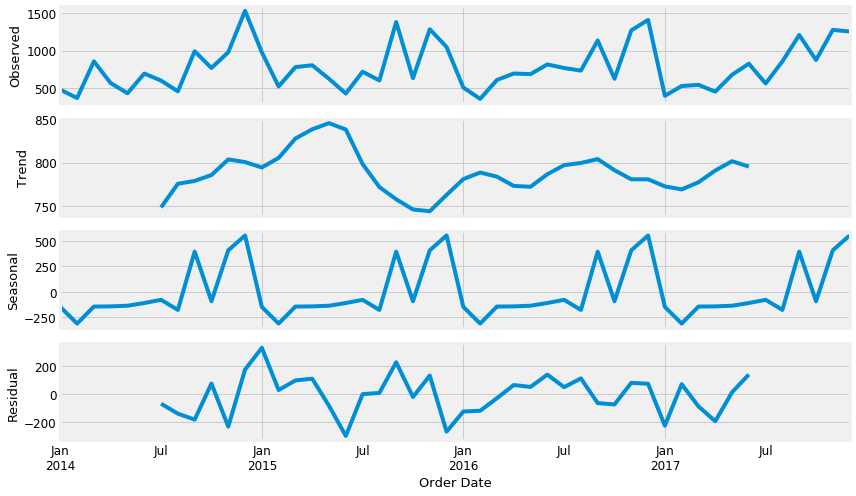

In [23]:
# Decompose time series into three distinct components: trend, seasonality, and noise.
from pylab import rcParams
rcParams['figure.figsize'] = 12, 7
decomposition = sm.tsa.seasonal_decompose(y, 
                                          model='additive')
fig = decomposition.plot()
plt.show()

#### Checks for Stationarity

> Time series are stationary if they do not have trend or seasonal effects. Summary statistics calculated on the time series are consistent over time, like the mean or the variance of the observations. When a time series is stationary, it can be easier to model. Statistical modeling methods assume or require the time series to be stationary to be effective.

> The **Augmented Dickey-Fuller** test is a type of statistical test called a **unit root test**. The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend. It uses an autoregressive model and optimizes an information criterion across multiple different lag values. <br>

> The null hypothesis of the test is that the time series can be represented by a **unit root**, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

> We interpret this result using the **p-value** from the test:<br>p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.<br>
p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [24]:
from statsmodels.tsa.stattools import adfuller
X = y.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.191070
p-value: 0.000009
Critical Values:
	1%: -3.621
	5%: -2.944
	10%: -2.610


**Remark:**<br>
- As part of the output, we get a look-up table to help determine the ADF statistic. We can see that our statistic value of -5.19 is less than the value of -3.631 at 1%.
- This suggests that we can **reject the null hypothesis** with a significance level of less than 1% (i.e. a low probability that the result is a statistical fluke).
- Rejecting the null hypothesis means that the process has **no unit root**, and in turn that the time series is stationary or does not have time-dependent structure.
- If the series was in fact non-stationary, a **log transformation** could be applied and the test run again to check for stationarity.

### Forecasting with ARIMA

> **AutoregRessive Integrated Moving Average** (ARIMA) is a model that can be fitted to time series data in order to better understand or predict future points in the series.

> There are three distinct integers **(p, d, q)** that are used to parametrize ARIMA models. Because of that, ARIMA models are denoted with the notation **ARIMA(p, d, q)**. Together these three parameters account for seasonality, trend, and noise in datasets:
 - **p** is the **auto-regressive** part of the model. It allows us to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.
 - **d** is the **integrated** part of the model. This includes terms in the model that incorporate the amount of differencing (i.e. the number of past time points to subtract from the current value) to apply to the time series. Intuitively, this would be similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.
 - **q** is the **moving average** part of the model. This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.

> When dealing with **seasonal effects**, we make use of the **seasonal ARIMA**, which is denoted as **ARIMA(p,d,q)(P,D,Q)s**. Here, (p, d, q) are the non-seasonal parameters described above, while **(P, D, Q)** follow the same definition but are applied to the seasonal component of the time series. The term s is the periodicity of the time series (4 for quarterly periods, 12 for yearly periods, etc.).

#### GridSeach to find optimal parameters for SARIMA algorithm

In [25]:
# define parameter range for GridSearch parameter search
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# create a dataframe to store GridSearch results
col = ['pdq parameters', 'season pdq', 'AIC score']
df_results = pd.DataFrame(columns=col)
i = 0
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            #print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            df_results.loc[i] = [param, param_seasonal, round(results.aic, 2)]
            i += 1
        except:
            continue
df_results = df_results.sort_values(
    by=['AIC score'], ascending=True).reset_index(drop=True)
best_score = df_results['AIC score'].values[0]
pdq_opt = df_results['pdq parameters'].values[0]
season_pdq_opt = df_results['season pdq'].values[0]
print("Best score is {} with pdq {} and seasonal pdq: {}".format(
    best_score, pdq_opt, season_pdq_opt))

Best score is 297.79 with pdq (1, 1, 1) and seasonal pdq: (1, 1, 0, 12)


- Performance metric: **AIC** (Akaike Information Criteria) is a widely used measure of a statistical model. It basically quantifies 1) the goodness of fit, and 2) the simplicity/parsimony, of the model into a single statistic. When comparing two models, the one with the **lower AIC is generally “better”**.

#### Fitting the SARIMA model

> The summary attribute that results from the output of SARIMAX returns a significant amount of information, but we'll focus our attention on the **table of coefficients**. <br> The coef column shows the **weight (i.e. importance) of each feature** and how each one impacts the time series. <br> The **P>|z|** column informs us of the significance of each feature weight. <br>
If the p-value for certain parameters is greater than **0.05**, one should consider removing it.

In [26]:
## Fitting the ARIMA model with the optimal parameters
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                   48
Model:             SARIMAX(1, 1, 1)x(1, 1, 0, 12)   Log Likelihood                -144.894
Date:                            Sun, 14 Jul 2019   AIC                            297.788
Time:                                    15:39:38   BIC                            302.152
Sample:                                01-01-2014   HQIC                           298.816
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0146      0.342      0.043      0.966      -0.655       0.684
ma.L1         -1.0000      0.360   

### Model diagnostics

> When fitting seasonal ARIMA models (and any other models for that matter), it is important to run model diagnostics to ensure that none of the assumptions made by the model have been violated. <br>
The **plot_diagnostics** object allows us to quickly generate model diagnostics and investigate for any unusual behavior.

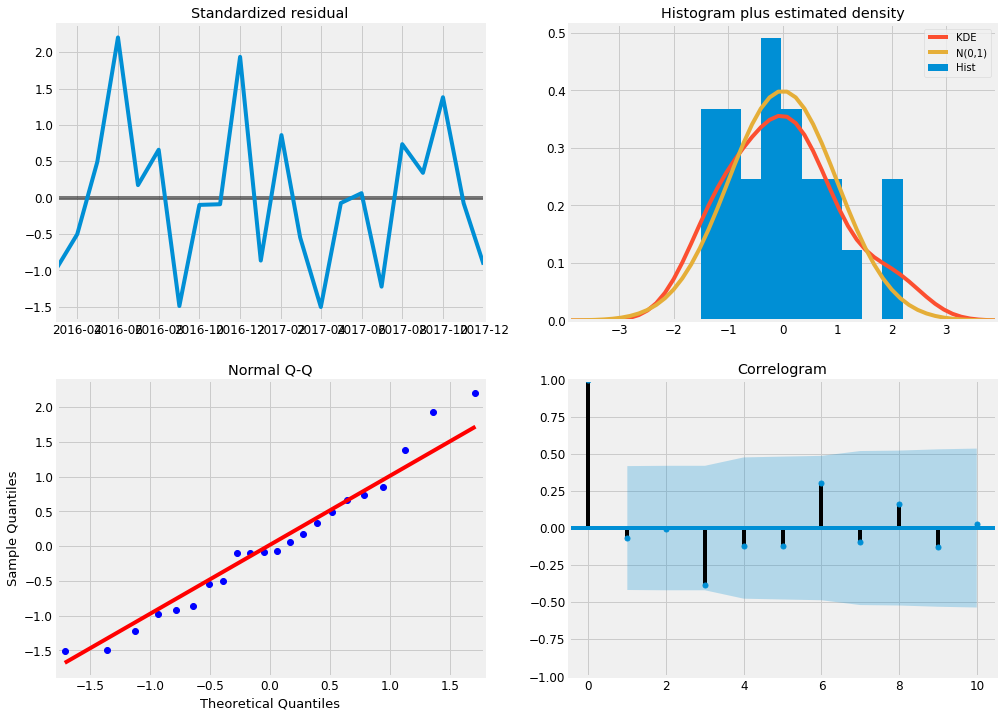

In [27]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

Our primary concern is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If the seasonal ARIMA model does not satisfy these properties, it is a good indication that it can be further improved. In this case, our model diagnostics suggests that the model residuals are normally distributed based on the following:

- In the top right plot, we see that the **red KDE line** follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.

- The **qq-plot** on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.

- The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the **autocorrelation (i.e. correlogram)** plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself. <br>

Those observations lead us to conclude that our model produces a satisfactory fit that could help us understand our time series data and forecast future values.

### Forecast Validation

#### Plotting Predicted vs. Known Observations

We have obtained a model for our time series that can now be used to produce forecasts. We start by **comparing predicted values to real values** of the time series, which will help us understand the accuracy of our forecasts. <br>
The **get_prediction()** and **conf_int()** attributes allow us to obtain the values and associated confidence intervals for forecasts of the time series.

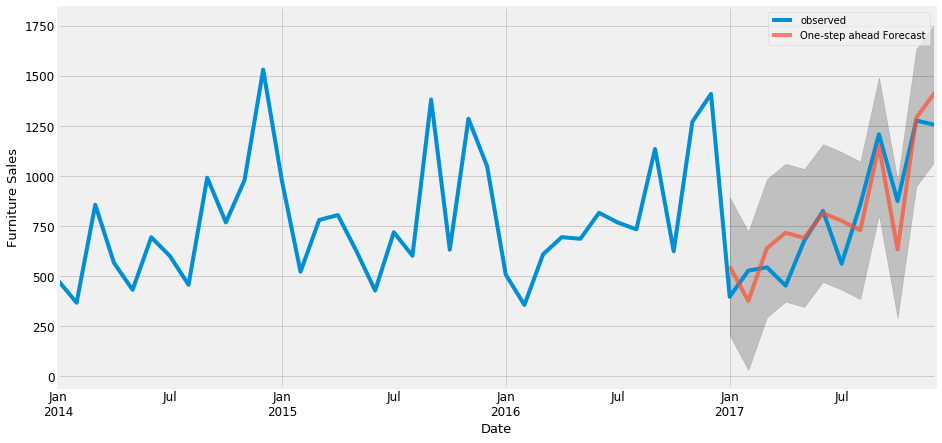

In [28]:
# get predictions
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'),
                              dynamic=False)
# The dynamic=False argument ensures that we produce one-step ahead forecasts,
# meaning that forecasts at each point are generated using the full history up to that point.

# get confidence intervals for forecasts of the time series
pred_ci = pred.conf_int()

# plot predictions with confidence intervals
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(
    ax=ax, 
    label='One-step ahead Forecast', 
    alpha=.7, 
    figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], 
                color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [29]:
# predictions from SARIMA model
pred.predicted_mean.head(3)

Order Date
2017-01-01    550.097314
2017-02-01    376.886097
2017-03-01    640.883932
Freq: MS, dtype: float64

In [30]:
## Output dataframe with forecast lower and upper bounds
pred_ci.head()

lower Sales  upper Sales
Order Date                          
2017-01-01   204.676401   895.518227
2017-02-01    31.859480   721.912714
2017-03-01   296.216052   985.551813
2017-04-01   373.137945  1061.818148
2017-05-01   347.351126  1035.430000

#### Performance Metric

> It is also useful to **quantify the accuracy of our forecasts**. We will use the **MSE (Mean Squared Error)**, which summarizes the average error of our forecasts. For each predicted value, we compute its distance to the true value and square the result. The results need to be squared so that positive/negative differences do not cancel each other out when we compute the overall mean.

In [31]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is: {:,}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts: is {:,}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is: 22,993.58
The Root Mean Squared Error of our forecasts: is 151.64


Root Mean Square Error (RMSE) tells us that our model was able to forecast the average daily furniture sales in the test set **within 151.64 of the real sales**. Our furniture daily sales range from around 400 to over 1200. In my opinion, this is a pretty good model so far.

### SARIMA (Future) Forecast Ouput

The **get_forecast()** attribute of our time series object can compute forecasted values for a specified number of **steps** ahead.

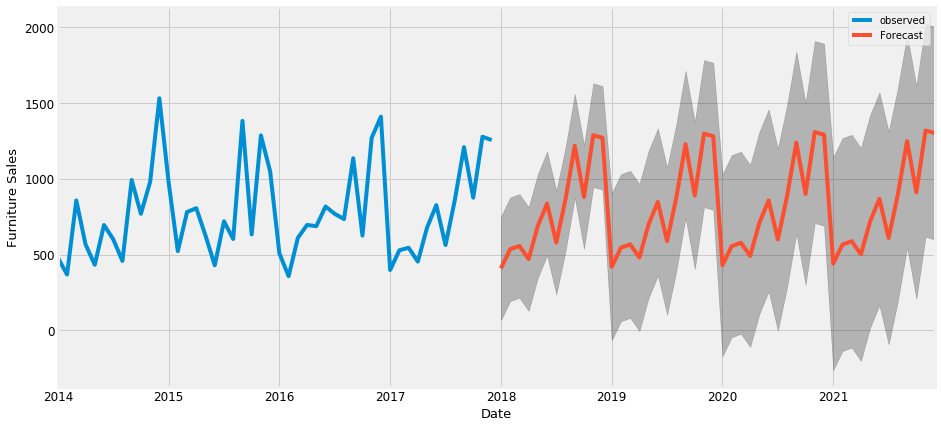

In [32]:
pred_uc = results.get_forecast(steps=48)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

As we forecast further out into the future, it is natural for us to become less confident in our values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future. <br>
Here are a few other things you could also try:
- Change the start date of your dynamic forecasts to see how this affects the overall quality of your forecasts.
- Try more combinations of parameters to see if you can improve the goodness-of-fit of your model.

## Comparing Furniture and Office Supplies Sales

### Data Processing

In [33]:
# glance at master dataframe
df.head(1)

Row ID        Order ID Order Date  Ship Date     Ship Mode Customer ID  \
0       1  CA-2016-152156 2016-11-08 2016-11-11  Second Class    CG-12520   

  Customer Name   Segment        Country       City     State  Postal Code  \
0   Claire Gute  Consumer  United States  Henderson  Kentucky        42420   

  Region       Product ID   Category Sub-Category  \
0  South  FUR-BO-10001798  Furniture    Bookcases   

                        Product Name   Sales  Quantity  Discount   Profit  
0  Bush Somerset Collection Bookcase  261.96         2       0.0  41.9136

In [34]:
# Category types
df['Category'].unique()

array(['Furniture', 'Office Supplies', 'Technology'], dtype=object)

In [35]:
# extract Furniture sales
df_furniture = df[df['Category']=='Furniture'].copy()
df_furniture.shape

(2121, 21)

In [36]:
# Extract Office Supplies sales
df_office = df[df['Category']=='Office Supplies'].copy()
df_office.shape

(6026, 21)

In [37]:
# remove unnecessary columns
df_office = df_office[['Order Date', 'Sales']].copy()
df_furniture = df_furniture[['Order Date', 'Sales']].copy()
print(df_furniture.shape, df_office.shape)

(2121, 2) (6026, 2)


In [38]:
# rename columns prior to concat
df_office.rename(columns={'Sales': 'office_sales'}, inplace=True)
df_furniture.rename(columns={'Sales': 'furniture_sales'}, inplace=True)

In [39]:
df_office.head()

Order Date  office_sales
2 2016-06-12        14.620
4 2015-10-11        22.368
6 2014-06-09         7.280
8 2014-06-09        18.504
9 2014-06-09       114.900

In [40]:
# sort dataframe by date
df_furniture.sort_values('Order Date')
df_furniture.reset_index(drop=True)

df_office.sort_values('Order Date')
df_office.reset_index(drop=True)
print('Dataframes sorted by Order Date')

Dataframes sorted by Order Date


In [41]:
# Group sales by order date, and sum them up
df_furniture = df_furniture.groupby('Order Date')['furniture_sales'].sum().reset_index()
df_office = df_office.groupby('Order Date')['office_sales'].sum().reset_index()

In [42]:
# set orderdate as index
df_furniture = df_furniture.set_index('Order Date')
df_office = df_office.set_index('Order Date')

In [43]:
# resamplign dataframe into monthly averages with start of each month as the timestamp.
furniture_y = df_furniture['furniture_sales'].resample("MS").mean().copy()
office_y = df_office['office_sales'].resample("MS").mean().copy()

In [44]:
furniture_y.head()

Order Date
2014-01-01    480.194231
2014-02-01    367.931600
2014-03-01    857.291529
2014-04-01    567.488357
2014-05-01    432.049187
Freq: MS, Name: furniture_sales, dtype: float64

In [45]:
office_y.head()

Order Date
2014-01-01    285.357647
2014-02-01     63.042588
2014-03-01    391.176318
2014-04-01    464.794750
2014-05-01    324.346545
Freq: MS, Name: office_sales, dtype: float64

In [46]:
# create dataframess with resampled sales data
furniture = pd.DataFrame(
    {'Order Date': furniture_y.index, 'Furniture_Sales': furniture_y.values})
office = pd.DataFrame({'Order Date': office_y.index, 'Office_Sales': office_y.values})
print(furniture.shape, office.shape)

(48, 2) (48, 2)


In [47]:
# Merge two dataframes
df_sales = furniture.merge(office, how='outer', on='Order Date')
print(df_sales.shape)

(48, 3)


In [48]:
# set Order Date as index
df_sales_or = df_sales.copy()
df_sales = df_sales.set_index('Order Date')
df_sales.head()

Furniture_Sales  Office_Sales
Order Date                               
2014-01-01       480.194231    285.357647
2014-02-01       367.931600     63.042588
2014-03-01       857.291529    391.176318
2014-04-01       567.488357    464.794750
2014-05-01       432.049187    324.346545

### Plotting Sales Data

In [49]:
# get data in long-format
df_melt = df_sales_or.melt(id_vars='Order Date', 
                        value_vars=['Furniture_Sales', 'Office_Sales'])
# plot using Plotly Express
px.line(df_melt, 
        x='Order Date' , 
        y='value' , 
        color='variable')

In [52]:
store = df_sales.copy()
store.head(1)

Furniture_Sales  Office_Sales
Order Date                               
2014-01-01       480.194231    285.357647

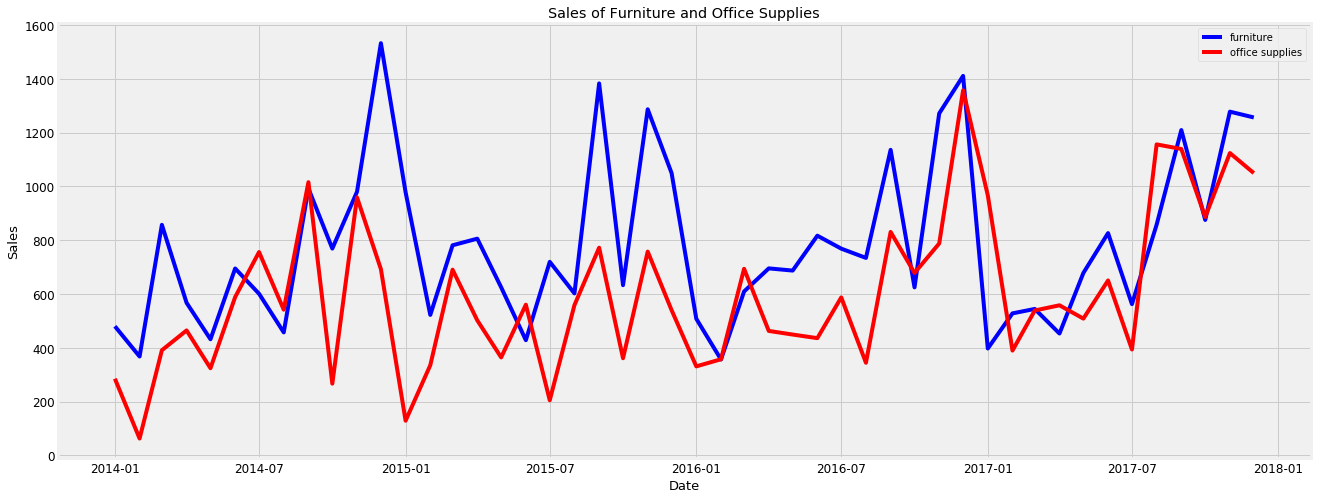

In [53]:
plt.figure(figsize=(20, 8))
plt.plot(store.index, store['Furniture_Sales'], 'b-', label = 'furniture')
plt.plot(store.index, store['Office_Sales'], 'r-', label = 'office supplies')
plt.xlabel('Date'); 
plt.ylabel('Sales'); 
plt.title('Sales of Furniture and Office Supplies')
plt.legend();

> Occasionally, office supplies passed furniture on average daily sales. Let’s find out when was the first time office supplies’ sales surpassed those of furniture’s.

In [54]:
store['Order Date'] = store.index
first_date = store.ix[np.min(list(
    np.where(store['Office_Sales'] > store['Furniture_Sales'])[0])),
    'Order Date']
print("Office supplies first time produced higher sales than furniture is {}.".format(
    first_date.date()))

Office supplies first time produced higher sales than furniture is 2014-07-01.


## Forecasting with Prophet

Forecasting tool **Prophet** (released by Facebook) is designed for analyzing time-series that display patterns on different time scales such as yearly, weekly and daily. It also has advanced capabilities for modeling the effects of holidays on a time-series and implementing custom changepoints. 

Implements a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

In [55]:
from fbprophet import Prophet

### Furniture

#### Data Preparation

The Prophet library expects as **input a DataFrame** with one column containing the time information, and another column containing the metric that we wish to forecast. Importantly, the time column is expected to be of the **datetime type**, so let's check the type of our columns.

In [56]:
furniture.head(1)

Order Date  Furniture_Sales
0 2014-01-01       480.194231

In [57]:
furniture.dtypes

Order Date         datetime64[ns]
Furniture_Sales           float64
dtype: object

> Prophet also imposes the strict condition that the i**nput columns be named ds (the time column) and y (the metric column)**, so let's rename the columns in our DataFrame:

In [58]:
furniture_fb = furniture.rename(columns={'Order Date': 'ds', 
                                         'Furniture_Sales': 'y'})
furniture_fb.head(1)

ds           y
0 2014-01-01  480.194231

#### Prophet Sales Forecasting

> To begin, we must instantiate a **new Prophet object**. Prophet enables us to specify a number of arguments. For example, we can specify the desired range of our **uncertainty interval** by setting the interval_width parameter.

In [59]:
# fitting Prophet to furniture sales data
furniture_model = Prophet(interval_width=0.95, # set the uncertainty interval to 95% (default is 80%)
                          daily_seasonality=False,
                          weekly_seasonality=False)
furniture_model.fit(furniture_fb)

> In order to obtain forecasts of our time series, we must provide Prophet with a new DataFrame containing a ds column that holds the dates for which we want predictions. Conveniently, we do not have to concern ourselves with manually creating this DataFrame, as Prophet provides the **make_future_dataframe** helper function.

In [60]:
# create Prophet sales forecast for furniture
furniture_forecast = furniture_model.make_future_dataframe(
    periods=36, freq='MS') # we instructed Prophet to generate 36 datestamps in the future
print(type(furniture_forecast))

<class 'pandas.core.frame.DataFrame'>


In [61]:
furniture_forecast.head(3)

ds
0 2014-01-01
1 2014-02-01
2 2014-03-01

In [62]:
furniture_pred = furniture_model.predict(furniture_forecast)
print(type(furniture_pred))

<class 'pandas.core.frame.DataFrame'>


When working with Prophet, it is important to consider the frequency of our time series. Because we are working with monthly data, we clearly specified the desired frequency of the timestamps (in this case, MS is the start of the month). Therefore, the make_future_dataframe generated 36 monthly timestamps for us. In other words, we are looking to predict future values of our time series 3 years into the future.

> Prophet returns a large DataFrame with many interesting columns, but we subset our output to the columns most relevant to forecasting, which are:
- ds: the datestamp of the forecasted value
- yhat: the forecasted value of our metric (in Statistics, yhat is a notation traditionally used to represent the predicted values of a value y)
- yhat_lower: the lower bound of our forecasts
- yhat_upper: the upper bound of our forecasts

In [63]:
furniture_pred.head(3)

ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2014-01-01  726.057713  302.424230  785.922213   726.057713   726.057713   
1 2014-02-01  727.494023  194.757863  686.208964   727.494023   727.494023   
2 2014-03-01  728.791335  460.797280  956.283774   728.791335   728.791335   

   additive_terms  additive_terms_lower  additive_terms_upper      yearly  \
0     -190.685662           -190.685662           -190.685662 -190.685662   
1     -276.377703           -276.377703           -276.377703 -276.377703   
2      -22.389755            -22.389755            -22.389755  -22.389755   

   yearly_lower  yearly_upper  multiplicative_terms  \
0   -190.685662   -190.685662                   0.0   
1   -276.377703   -276.377703                   0.0   
2    -22.389755    -22.389755                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper        yhat  
0                         0.0                         0.0  535.372051  
1                         0.0                         0.0  451.116320  
2                         0.0                         0.0  706.401580

> Prophet relies on **Markov chain Monte Carlo (MCMC)** methods to generate its forecasts. <br>
MCMC is a **stochastic process**, so values will be slightly different each time.

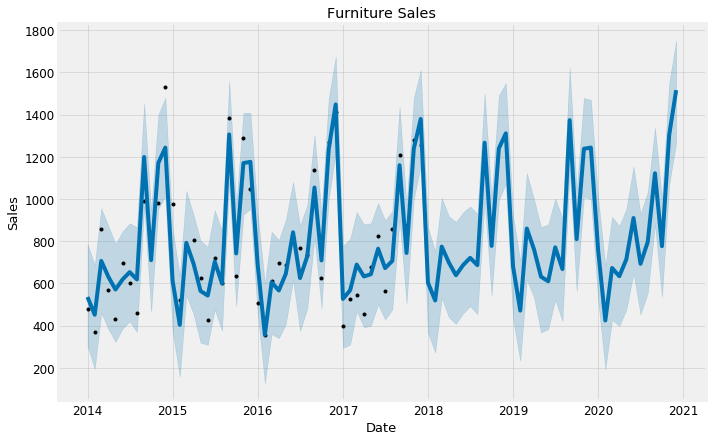

In [64]:
plt.figure(figsize=(18, 6))
furniture_model.plot(furniture_pred, 
                     xlabel='Date', 
                     ylabel='Sales', 
                     uncertainty=True)
plt.title('Furniture Sales');

Prophet plots: 
- the **observed** values of our time series (the black dots), 
- the **forecasted** values (blue line) and 
- the **uncertainty intervals** of our forecasts (the blue shaded regions).

> One other particularly strong feature of Prophet is its ability to return the components of our forecasts. This can help reveal how daily, weekly and yearly patterns of the time series contribute to the overall forecasted values:

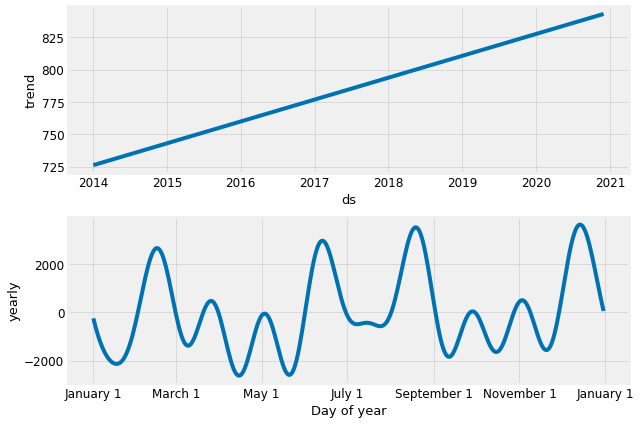

In [65]:
furniture_model.plot_components(furniture_pred);

The plot above provides interesting insights:
- The first plot shows that the yearly volume of sales has been linearly increasing over time. 
- The second plot highlights the fact that the monthly count of passengers peaks tin Feb, June, August and December.

### Office Supplies

#### Data Processing

In [117]:
# extract Office Supplies sales from Master df
df_office = df[df['Category']=='Office Supplies'].copy()
df_office.shape

# extract desired columns
df_office_sales = df_office[['Order Date', 'Sales']].copy()
print(df_office_sales.shape)

# 1. sort sales by date
df_office = df_office_sales.sort_values('Order Date').reset_index(drop=True)
print(df_office.shape)

# 2. group sales by order date
df_office = df_office.groupby('Order Date')['Sales'].sum().reset_index()

# 3. set orderdate as index
df_office = df_office.set_index('Order Date')
print(df_office.shape)

# 4. resamplign dataframe into monthly averages with start of each month as the timestamp.
office_y = df_office['Sales'].resample("MS").mean().copy()
print(office_y.head())

(6026, 2)
(6026, 2)
(1148, 1)
Order Date
2014-01-01    285.357647
2014-02-01     63.042588
2014-03-01    391.176318
2014-04-01    464.794750
2014-05-01    324.346545
Freq: MS, Name: Sales, dtype: float64


In [118]:
# set up dataframe for Prophet timeseries forecasting
df_office_fb = office_y.to_frame()
df_office_fb['Order Date'] = df_office_fb.index
# reset index
df_office_fb = df_office_fb.reset_index(drop=True)
df_office_fb.head(3)

Sales Order Date
0  285.357647 2014-01-01
1   63.042588 2014-02-01
2  391.176318 2014-03-01

In [119]:
df_office_fb.dtypes

Sales                float64
Order Date    datetime64[ns]
dtype: object

In [120]:
df_office_fb = df_office_fb.rename(columns={'Order Date': 'ds', 
                                         'Sales': 'y'})
df_office_fb.head(3)

y         ds
0  285.357647 2014-01-01
1   63.042588 2014-02-01
2  391.176318 2014-03-01

#### Prophet Timeseries Forecasting

In [121]:
# fitting Prophet to furniture sales data
office_model = Prophet(interval_width=0.95,  # set the uncertainty interval to 95% (default is 80%)
                       daily_seasonality=False,
                       weekly_seasonality=False)
office_model.fit(df_office_fb)

In [122]:
# create Prophet sales forecast for furniture
office_forecast = office_model.make_future_dataframe(
    periods=36, freq='MS') # we instructed Prophet to generate 36 datestamps in the future
print(type(office_forecast))

<class 'pandas.core.frame.DataFrame'>


In [123]:
office_pred = office_model.predict(office_forecast)
print(type(office_pred))

<class 'pandas.core.frame.DataFrame'>


In [124]:
office_pred.head(3)

ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2014-01-01  487.530759   60.731160  634.061716   487.530759   487.530759   
1 2014-02-01  494.918445 -209.629035  404.129170   494.918445   494.918445   
2 2014-03-01  501.591193  193.807548  768.802937   501.591193   501.591193   

   additive_terms  additive_terms_lower  additive_terms_upper      yearly  \
0     -140.040481           -140.040481           -140.040481 -140.040481   
1     -385.678283           -385.678283           -385.678283 -385.678283   
2      -31.379844            -31.379844            -31.379844  -31.379844   

   yearly_lower  yearly_upper  multiplicative_terms  \
0   -140.040481   -140.040481                   0.0   
1   -385.678283   -385.678283                   0.0   
2    -31.379844    -31.379844                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper        yhat  
0                         0.0                         0.0  347.490278  
1                         0.0                         0.0  109.240162  
2                         0.0                         0.0  470.211349

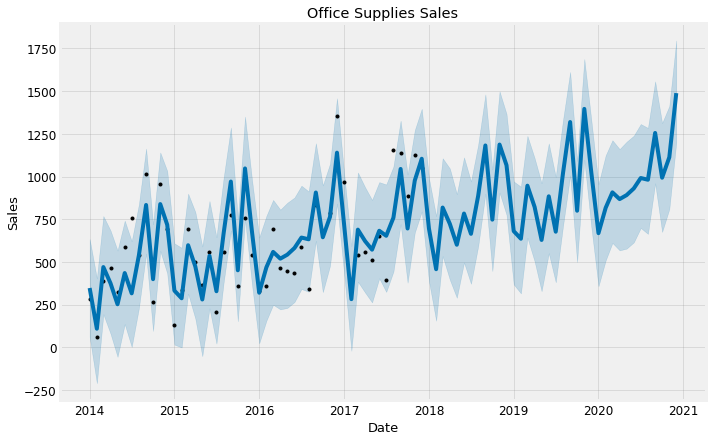

In [125]:
plt.figure(figsize=(18, 6))
office_model.plot(office_pred,
                  xlabel='Date',
                  ylabel='Sales',
                  uncertainty=True)
plt.title('Office Supplies Sales');

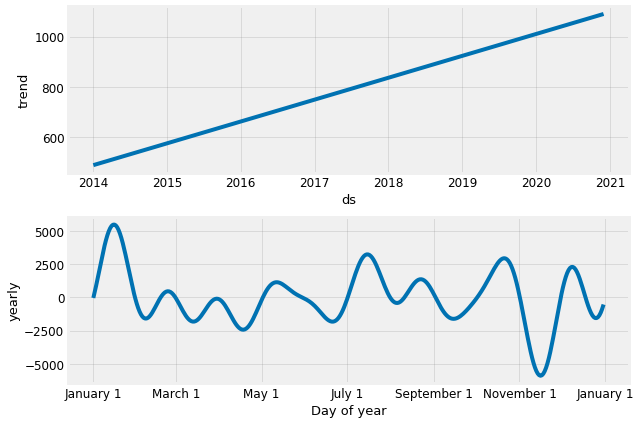

In [126]:
office_model.plot_components(office_pred);

## Joined Time Series of Furniture &. Office Supplies

### Data Processing

In [129]:
## 1. get data
furniture = df.loc[df['Category'] == 'Furniture']
office = df.loc[df['Category'] == 'Office Supplies']
furniture.shape, office.shape
## 2. remove unecessary columns
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 
        'Customer Name', 'Segment', 'Country', 'City', 'State',
        'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 
        'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
office.drop(cols, axis=1, inplace=True)
## 3. sort sales data by Order Dates
furniture = furniture.sort_values('Order Date')
office = office.sort_values('Order Date')
## 4. group and sum sales data by order data
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
office = office.groupby('Order Date')['Sales'].sum().reset_index()
# 5. set OrderDate as the df's index
furniture = furniture.set_index('Order Date')
office = office.set_index('Order Date')
# 6. resample the sales data by month, first day of the month as the timestamp
y_furniture = furniture['Sales'].resample('MS').mean()
y_office = office['Sales'].resample('MS').mean()
# 7. create dataframes with sales data
furniture = pd.DataFrame(
    {'Order Date': y_furniture.index, 'Sales': y_furniture.values})
office = pd.DataFrame({'Order Date': y_office.index, 'Sales': y_office.values})
# 8. merge both dataframes into a one dataframe
store = furniture.merge(office, how='outer', on='Order Date')
# 9. rename the columns
store.rename(columns={'Sales_x': 'furniture_sales',
                      'Sales_y': 'office_sales'}, inplace=True)
# 10. show first rows of combined sales data dataframe
store.head()

Order Date  furniture_sales  office_sales
0 2014-01-01       480.194231    285.357647
1 2014-02-01       367.931600     63.042588
2 2014-03-01       857.291529    391.176318
3 2014-04-01       567.488357    464.794750
4 2014-05-01       432.049188    324.346545

In [151]:
# get data in long-format
df_meltv2 = store.melt(id_vars='Order Date', 
                      value_vars=['furniture_sales', 'office_sales'])
# plot using Plotly Express
px.line(df_meltv2, 
        x='Order Date' , 
        y='value' , 
        color='variable')

> Occasionally, office supplies passed furniture on average daily sales. Let’s find out when was the first time office supplies’ sales surpassed those of furniture’s.

In [131]:
first_date = store.ix[np.min(list(
    np.where(store['office_sales'] > store['furniture_sales'])[0])),
    'Order Date']
print("Office supplies first time produced higher sales than furniture is {}.".format(
    first_date.date()))

Office supplies first time produced higher sales than furniture is 2014-07-01.


### Trends and Prophet Forecasts Visualization

In [133]:
# get column names of Prophet forecast output dataframes
furniture_names = ['furniture_%s' % column for column in furniture_pred.columns]
office_names = ['office_%s' % column for column in office_pred.columns]

In [137]:
furniture_pred.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [143]:
# copy Prophet sales forecast data
merge_furniture_forecast = furniture_pred.copy()
merge_office_forecast = office_pred.copy()
# assigning new columns names to forecast dataframes
merge_furniture_forecast.columns = furniture_names
merge_office_forecast.columns = office_names

In [144]:
# merge dataframes
forecast = pd.merge(merge_furniture_forecast, 
                    merge_office_forecast, 
                    how = 'inner', 
                    left_on = 'furniture_ds', 
                    right_on = 'office_ds')
forecast = forecast.rename(columns={'furniture_ds': 'Date'}).drop('office_ds', axis=1)
print(merge_furniture_forecast.shape, merge_office_forecast.shape, forecast.shape)
forecast.head()

(84, 16) (84, 16) (84, 31)


Date  furniture_trend  furniture_yhat_lower  furniture_yhat_upper  \
0 2014-01-01       726.057713            302.424230            785.922213   
1 2014-02-01       727.494023            194.757863            686.208964   
2 2014-03-01       728.791335            460.797280            956.283774   
3 2014-04-01       730.227645            382.783176            870.405592   
4 2014-05-01       731.617622            323.060919            786.754073   

   furniture_trend_lower  furniture_trend_upper  furniture_additive_terms  \
0             726.057713             726.057713               -190.685662   
1             727.494023             727.494023               -276.377703   
2             728.791335             728.791335                -22.389755   
3             730.227645             730.227645               -100.141158   
4             731.617622             731.617622               -160.815662   

   furniture_additive_terms_lower  furniture_additive_terms_upper  \
0                     -190.685662                     -190.685662   
1                     -276.377703                     -276.377703   
2                      -22.389755                      -22.389755   
3                     -100.141158                     -100.141158   
4                     -160.815662                     -160.815662   

   furniture_yearly  furniture_yearly_lower  furniture_yearly_upper  \
0       -190.685662             -190.685662             -190.685662   
1       -276.377703             -276.377703             -276.377703   
2        -22.389755              -22.389755              -22.389755   
3       -100.141158             -100.141158             -100.141158   
4       -160.815662             -160.815662             -160.815662   

   furniture_multiplicative_terms  furniture_multiplicative_terms_lower  \
0                             0.0                                   0.0   
1                             0.0                                   0.0   
2                             0.0                                   0.0   
3                             0.0                                   0.0   
4                             0.0                                   0.0   

   furniture_multiplicative_terms_upper  furniture_yhat  office_trend  \
0                                   0.0      535.372051    487.530759   
1                                   0.0      451.116320    494.918445   
2                                   0.0      706.401580    501.591193   
3                                   0.0      630.086487    508.978878   
4                                   0.0      570.801960    516.128251   

   office_yhat_lower  office_yhat_upper  office_trend_lower  \
0          60.731160         634.061716          487.530759   
1        -209.629035         404.129170          494.918445   
2         193.807548         768.802937          501.591193   
3          79.593000         683.483371          508.978878   
4         -55.424285         566.941650          516.128251   

   office_trend_upper  office_additive_terms  office_additive_terms_lower  \
0          487.530759            -140.040481                  -140.040481   
1          494.918445            -385.678283                  -385.678283   
2          501.591193             -31.379844                   -31.379844   
3          508.978878            -134.291690                  -134.291690   
4          516.128251            -263.821569                  -263.821569   

   office_additive_terms_upper  office_yearly  office_yearly_lower  \
0                  -140.040481    -140.040481          -140.040481   
1                  -385.678283    -385.678283          -385.678283   
2                   -31.379844     -31.379844           -31.379844   
3                  -134.291690    -134.291690          -134.291690   
4                  -263.821569    -263.821569          -263.821569   

   office_yearly_upper  office_multiplicative_terms  \
0          -140.040481          

In [152]:
# get data in long-format
df_meltv3 = forecast.melt(id_vars='Date',
                          value_vars=['furniture_trend', 'office_trend'])
# plot using Plotly Express
px.line(df_meltv3,
        x='Date',
        y='value',
        color='variable')

In [153]:
# get data in long-format
df_meltv4 = forecast.melt(id_vars='Date', 
                      value_vars=['furniture_yhat', 'office_yhat'])
# plot using Plotly Express
px.line(df_meltv4, 
        x='Date' , 
        y='value' , 
        color='variable')